In [197]:
import json
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
mainfile = "result_2023_6_8.json"
maindata = []
with open(mainfile, 'r') as f:
  for entry in f:
      oneEntry = json.loads(entry)
      maindata.append(oneEntry)

# Data Analysis for JSON Files (draft)
Looking into website leak data from edutech extension. Written up version of exploratory data analysis. <br>
**Mentor:** Jake Chanesson,   **Research Assistant:** Shayona Basu

Data produced by **AirLAB**

### Removing data entries where the json file has no report data saved:

In [6]:
filtered_data = []
for d in maindata: 
  if d.get('report') != None: #not empty
    if d.get('report').get('user_id') != None: 
      filtered_data.append(d)

In [7]:
f"After the initial filtiration there are {len(filtered_data)} entries, when there were initially {len(maindata)} entries"

'After the initial filtiration there are 533229 entries, when there were initially 688185 entries'

I am curious to check what actually consists of empty data. I am defining empty data as data where reports are made, but there is no user_id. I am going to go through and explore what the empty data consists of. I believe this can be useful to understand we are not using, and confirming it is empty. 

In [8]:
empty_data = []
for d in maindata: 
    if d.get('report') != None: 
        if d.get('report').get('user_id') == None:
            empty_data.append(d)
print(f"There are {len(empty_data)} entries of json data with reports but no user")

There are 139405 entries of json data with reports but no user


Printing a random entry of the empty dataset

In [ ]:
empty_data[38473]

From checking this random entry, we see there is seemingly useful amount of information, so I think we should edit how our first stage of filtering, and potentially include reports where there is no user_id. We can save the data with no user_id, in its own group and continue to do website analysis

In [9]:
print(f'Of all the data entries from the files, the initial filtration removes {round(len(empty_data)/len(maindata) *100,2)}%' )

Of all the data entries from the files, the initial filtration removes 20.26%


In [10]:
filtered_data1 = []
for d in maindata: 
  if d.get('report') != None: #not empty
    if d.get('report').get('initiator_domain') != None: 
        filtered_data1.append(d)

I think maybe a better initial filtering would be to remove data where the initiator domain data is not collected. I think now is a good time to define two important cateogires for websites collected, throughout the rest of this data analysis <br>
**Initiator Domain:**   The website where the user lands, where the leak then occurs. 
**Tracker URL:**   The website of which the tracker owns, and where the leak actually happens

Documentation: https://homes.esat.kuleuven.be/~asenol/leaky-forms/ 

In [11]:
print(f'There are {len(filtered_data1)} websites that have the leak origin website data. Accordingly, there were {len(maindata)-len(filtered_data1)} entries, or {round(((len(maindata)-len(filtered_data1))/len(maindata))*100,2)}% removed in this updated initial filtration.')

There are 354159 websites that have the leak origin website data. Accordingly, there were 334026 entries, or 48.54% removed in this updated initial filtration.


### Here is an example entry of the new filtered dataset: 

In [12]:
filtered_data1[200000]

{'_id': {'$oid': '64583ff53d17c352fa865bb5'},
 'report': {'user_id': 'dknglbh1h3',
  'school_district': 'Other',
  'grade': '6',
  'request_method': 'GET',
  'timestamp': '2023-05-08T00:04:12.190Z',
  'leak_url': 'hLEAKED_LASTNAMELEAKED_LASTNAMEps://signaler-pa.clienLEAKED_LASTNAMEs6.google.com/LEAKED_LASTNAME/LEAKED_LASTNAME/LEAKED_LASTNAMELEAKED_LASTNAME=8&LEAKED_LASTNAME=LEAKED_LASTNAME&key=LEAKED_LASTNAME&RID=LEAKED_LASTNAME&SID=LEAKED_LASTNAME&AID=6&LEAKED_LASTNAME=0&LEAKED_LASTNAME=xmlhLEAKED_LASTNAMELEAKED_LASTNAMEp&zx=LEAKED_LASTNAME&LEAKED_LASTNAME=1',
  'initiator_domain': 'https://calendar.google.com/',
  'url_leak_type': ['lastname'],
  'body_leak_type': [],
  'tracker_info': {'action': 'ignore',
   'reason': 'first party',
   'firstParty': True,
   'redirectUrl': False,
   'matchedRule': None,
   'matchedRuleException': False,
   'tracker': {'domain': 'google.com',
    'owner': {'name': 'Google LLC',
     'displayName': 'Google',
     'privacyPolicy': 'https://policies.goo

## Starting the Data Analysis

Now, I will begin to make sense of reduced dataset, `filtered_data1`. As per the definitions a few cells above, I will now go through the filtered data set, and collect the Initiator URL and the Leak URL, and present it in a table.

In [13]:
#Saving Leak_URLS and Origin_URLS
Leak_URLS = []
Origin_URLS = []
for d in filtered_data1: 
    rep = d['report']
    Origin_URLS.append(rep['initiator_domain'])
    if rep.get('tracker_info') != None: 
        #some reports do not have tracker info
        if rep['tracker_info'].get('tracker').get('owner').get('url') != None: 
            #all reports with tracker info, have the following
            Leak_URLS.append(d['report']['tracker_info']['tracker']['owner']['url'])
        else: Leak_URLS.append("None")
    else: Leak_URLS.append("None")

Since writing data into a Pandas Dataframe requires both columns to be of the same length, I have to ammend my code a bit, by adding the string "None" when there is not a Leak_URl recorded. Here I am just ensuring both lists, which will be inputted as future column data, are the same length:

In [14]:
print(len(Leak_URLS), len(Origin_URLS))
LEAK_URLS_LEN = len(Leak_URLS)

354159 354159


In [15]:
df_leak_origin_urls = pd.DataFrame.from_dict({'Origin URLS': Origin_URLS,'Leak URLS': Leak_URLS})
df_leak_origin_urls.head(20)

,Origin URLS,Leak URLS
0,https://www.google.com/,http://google.com
1,https://www.google.com/,http://google.com
2,https://www.google.com/,http://google.com
3,https://www.google.com/,http://google.com
4,https://www.google.com/,http://google.com
5,https://www.google.com/,http://google.com
6,https://www.google.com/,http://google.com
7,https://www.google.com/,http://google.com
8,https://www.google.com/,http://google.com
9,https://www.youtube.com/,None


This is interesting, but presenting the data in this way is not letting us see a clear picture of what is happening. I want to find a way to get more useful data from this. First, let me start with seeing more of the origin urls. 

In [16]:
print(f'There are {len(set(Origin_URLS))} unique origin urls')

There are 65 unique origin urls


Now, let's see a more concise view of leak URLS if we group by origin URLS

In [17]:
grouped_df = df_leak_origin_urls.groupby('Origin URLS')['Leak URLS'].apply(set).reset_index(name = "Leak URLS")
grouped_df.head(20)

,Origin URLS,Leak URLS
0,https://accounts.google.com/,"{None, http://google.com}"
1,https://accounts.youtube.com/,"{None, http://google.com}"
2,https://acrobat.adobe.com/,"{http://demandbase.com, http://adobe.com, None}"
3,https://appsitemsuggest-pa.clients6.google.com/,{http://google.com}
4,https://c.paypal.com/,{http://paypal.com}
5,https://calendar.google.com/,"{None, http://google.com}"
6,https://calendly.com/,{None}
7,https://canvadocs.instructure.com/,"{http://cloudflare.com, http://heap.io, None}"
8,https://chat.google.com/,{http://google.com}
9,https://clients5.google.com/,"{None, http://google.com}"


This is a better view, but now let's make a bit more sense of it. First, let's section out all the websites where there are no Leak URLS. Ie, or where there is only one value, and it is "None"

#### Websites where we don't see leak URLS 

In [18]:
grouped_empty_df = grouped_df.loc[grouped_df["Leak URLS"] == {"None"}]
grouped_empty_df

,Origin URLS,Leak URLS
6,https://calendly.com/,{None}
15,https://eds.p.ebscohost.com/,{None}
17,https://edstem.org/,{None}
18,https://en.wikipedia.org/,{None}
19,https://github.com/,{None}
21,https://jetpack.wordpress.com/,{None}
31,https://pdc-evs.ebscohost.com/,{None}
35,https://public-api.wordpress.com/,{None}
39,https://sdc-evs.ebscohost.com/,{None}
41,https://service.force.com/,{None}


In [19]:
print(f'So, there are {len(grouped_empty_df.index)} websites from the 65 total where a leak is being triggered, but there isnt a leak url that is being saved.')

So, there are 17 websites from the 65 total where a leak is being triggered, but there isnt a leak url that is being saved.


### Those are the websites with no leaks, but let's see the websites with just "google.com" as the leak  - our version of noisy data?

In [20]:
grouped_google_df = grouped_df.loc[(grouped_df["Leak URLS"] == {"http://google.com"}) | (grouped_df["Leak URLS"] == {'None', "http://google.com"})]
grouped_google_df

,Origin URLS,Leak URLS
0,https://accounts.google.com/,"{None, http://google.com}"
1,https://accounts.youtube.com/,"{None, http://google.com}"
3,https://appsitemsuggest-pa.clients6.google.com/,{http://google.com}
5,https://calendar.google.com/,"{None, http://google.com}"
8,https://chat.google.com/,{http://google.com}
9,https://clients5.google.com/,"{None, http://google.com}"
10,https://clients6.google.com/,{http://google.com}
11,https://contacts.google.com/,"{None, http://google.com}"
14,https://drive.google.com/,"{None, http://google.com}"
20,https://groups.google.com/,"{None, http://google.com}"


Now, let's clean up the main Grouped By Data Frame. First, let's remove the empty Leak Url Rows (as extracted in the `grouped_empty_df` dataframe. There are also a lot of Leak URLS that just go to google.com, so let's remove those..<br>
Furthur, let's arrange the rows by amount of leak URLS found.

In [21]:
grouped_df.drop(grouped_df[grouped_df["Leak URLS"] == {"None"}].index, inplace = True)
grouped_df.drop(grouped_df[grouped_df["Leak URLS"] == {"http://google.com"}].index, inplace = True)
grouped_df.drop(grouped_df[grouped_df["Leak URLS"] == {'None', "http://google.com"}].index, inplace = True)
grouped_df['Count of Leak URLS'] = grouped_df['Leak URLS'].str.len()
grouped_df.sort_values(by = 'Count of Leak URLS',ascending = False, inplace=True)
grouped_df.reset_index(drop=True)

,Origin URLS,Leak URLS,Count of Leak URLS
0,https://quizlet.com/,"{http://thetradedesk.com, http://roku.com, htt...",55
1,https://uchicagossecretplaces.wordpress.com/,"{http://casalemedia.com, http://oracle.com, ht...",21
2,https://www.linkedin.com/,"{http://teads.tv, http://freewheel.tv, http://...",10
3,https://www.citationmachine.net/,"{http://cloudflare.com, None, http://brightcov...",8
4,https://www.nytimes.com/,"{http://thetradedesk.com, http://chartbeat.com...",7
5,https://www.google.com/,"{http://redditinc.com, None, http://akamai.com...",4
6,https://eds.s.ebscohost.com/,"{http://cloudflare.com, http://google.com, htt...",4
7,https://lightroom.adobe.com/,"{http://newrelic.com, http://akamai.com, http:...",4
8,https://outlook.office.com/,"{http://microsoft.com, http://google.com, http...",4
9,https://acrobat.adobe.com/,"{http://demandbase.com, http://adobe.com, None}",3


### Wow, look at Quizlet!

In [22]:
print(f'So, there are 55 websites where there are leaks. \nThose websites are:\n {grouped_df.iat[0,1]}')

So, there are 55 websites where there are leaks. 
Those websites are:
 {'http://thetradedesk.com', 'http://roku.com', 'http://mediamath.com', 'http://avocet.io', 'http://google.com', 'http://adform.com', 'http://casalemedia.com', 'http://conversantmedia.com', 'http://quantcast.com', 'http://oracle.com', 'http://openx.com', 'http://iponweb.com', 'http://verizon.com', 'http://facebook.com', 'http://disqus.com', 'http://sovrn.com', 'http://tapad.com', 'http://doubleverify.com', 'http://adotmob.com', 'http://pubmatic.com', 'http://storygize.com', 'http://smaato.com', 'http://adlightning.com', 'http://virtualminds.de', 'http://smartadserver.com', 'http://sonobi.com', 'http://pulsepoint.com', 'http://microsoft.com', 'http://magnite.com', 'http://criteo.com', 'http://trustarc.com', 'http://adyoulike.com', 'http://outbrain.com', 'http://adkernel.com', 'http://id5.io', 'http://adtheorent.com', 'http://stackadapt.com', 'http://33across.com', 'http://integralads.com', 'http://media.net', 'http://

## Taking another approach to the data
Instead of grouping by origin website, and removing potentially important counts such as how many times certain leaked websites occur, let's restructure our data. 

In [23]:
#list_zipped = zip(Origin_URLS, Leak_URLS)
#type(list(list_zipped))
df_leak_by_origin = pd.DataFrame.from_dict({'Tuple of Both': list(zip(Origin_URLS, Leak_URLS)),'Origin URLS': Origin_URLS,'Leak URLS': Leak_URLS})
df_leak_by_origin.drop(df_leak_by_origin[df_leak_by_origin["Leak URLS"] == {"None"}].index, inplace = True)
df_leak_by_origin.head(10)

,Tuple of Both,Origin URLS,Leak URLS
0,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
1,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
2,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
3,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
4,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
5,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
6,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
7,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
8,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
9,"(https://www.youtube.com/, None)",https://www.youtube.com/,None


Here, let's write a simple function that can be called many times throughout this data analysis. The function  goes through a list and produces a dictionary that counts how many times that entry appears, and sorts it in ascending order. I will then pass origin_urls through, and see what are the top websites where leaks occur from. The function returns it as a dictionairy, but I will present it as a table. 

In [24]:
def simple_produce_count(list):
    count_d = {}
    for i in list: 
        if i in count_d: 
            a = count_d.get(i)
            count_d[i] = a + 1
        else: 
            count_d[i] = 1
            
    return dict(sorted(count_d.items(), key=lambda x:x[1], reverse = True))

### An example of this method running on a simple search

In [25]:
orig_urls = simple_produce_count(Origin_URLS)
df_leak_origin_urls = pd.DataFrame.from_dict({'Origin of Leak Website URLS': list(orig_urls.keys()), 'Appearing': list(orig_urls.values())})
df_leak_origin_urls['Proportion (%)'] = round((df_leak_origin_urls.Appearing/len(Leak_URLS))*100,2)
df_leak_origin_urls.rename_axis("Index").head(30)

,Origin of Leak Website URLS,Appearing,Proportion (%)
Index,,,
0,https://docs.google.com/,135358,38.22
1,https://www.google.com/,60847,17.18
2,https://outlook.office.com/,42604,12.03
3,https://www.youtube.com/,31934,9.02
4,https://mail.google.com/,19071,5.38
5,https://www.linkedin.com/,8005,2.26
6,https://calendar.google.com/,7654,2.16
7,https://acrobat.adobe.com/,7405,2.09
8,https://www.facebook.com/,7041,1.99


*In the above table, I displayed the top 30 websites from the total 65 leak websites found in the data, for consideration of space. I will allow all tables to be presented in full format in the appendix*  <br>

#### Analysis on Google Docs being the source of the most leaks
So, we see that 38.2% of the leaks originate from Google Docs. It is also relevant to note that Google Docs is heavily used by students to write classwork and class projects. Furthur, the Google enviroment is a popular system that schools integrate into learning, and students store most of their school or personal related information. Therefore leaks relating to this would be of significance to educator's who care about student's online security. <br>

We see google.com, the search platform being responsible for 17.18% of the leaks, or 60,847 leaked data from students. Google Mail takes up 5.38% of the leaks, and Google Calender takes up 2.16%. The last significant source of leaks from the Google ecosystem is Google Calendar which has 2.16%.


#### Now going back and applying it to our main list

In [26]:
tracker_and_origin = simple_produce_count(list(zip(Origin_URLS, Leak_URLS)))
tracker_and_origin

{('https://docs.google.com/', 'http://google.com'): 134991,
 ('https://www.google.com/', 'http://google.com'): 58910,
 ('https://outlook.office.com/', 'None'): 42558,
 ('https://www.youtube.com/', 'None'): 29907,
 ('https://mail.google.com/', 'http://google.com'): 18931,
 ('https://calendar.google.com/', 'http://google.com'): 7649,
 ('https://www.linkedin.com/', 'http://microsoft.com'): 7475,
 ('https://acrobat.adobe.com/', 'None'): 7219,
 ('https://drive.google.com/', 'http://google.com'): 4362,
 ('https://edstem.org/', 'None'): 4211,
 ('https://www.facebook.com/', 'None'): 3969,
 ('https://www.facebook.com/', 'http://facebook.com'): 3072,
 ('https://chat.google.com/', 'http://google.com'): 3033,
 ('https://quizlet.com/', 'None'): 2949,
 ('https://ogs.google.com/', 'http://google.com'): 2184,
 ('https://www.youtube.com/', 'http://google.com'): 2027,
 ('https://www.google.com/', 'None'): 1933,
 ('https://lightroom.adobe.com/', 'http://newrelic.com'): 1922,
 ('https://meet.google.com/',

In [27]:
print(f'There are {len(tracker_and_origin.values())} unique Origin Websites and the Leak URL that is saved in a singular entry')

There are 209 unique Origin Websites and the Leak URL that is saved in a singular entry


In [28]:
list(tracker_and_origin.keys())
origin_1, leak_1 = map(list, zip(*list(tracker_and_origin.keys())
))
df_tracker_and_origin = pd.DataFrame.from_dict({'Origin URL': origin_1, 'Leak URL': leak_1, 'Appearances': list(tracker_and_origin.values())})
df_tracker_and_origin['Proportion (%)'] = round((df_tracker_and_origin.Appearances/LEAK_URLS_LEN)*100,2)
df_tracker_and_origin.head(20)

,Origin URL,Leak URL,Appearances,Proportion (%)
0,https://docs.google.com/,http://google.com,134991,38.12
1,https://www.google.com/,http://google.com,58910,16.63
2,https://outlook.office.com/,None,42558,12.02
3,https://www.youtube.com/,None,29907,8.44
4,https://mail.google.com/,http://google.com,18931,5.35
5,https://calendar.google.com/,http://google.com,7649,2.16
6,https://www.linkedin.com/,http://microsoft.com,7475,2.11
7,https://acrobat.adobe.com/,None,7219,2.04
8,https://drive.google.com/,http://google.com,4362,1.23
9,https://edstem.org/,None,4211,1.19


### Interesting - It seems google.com is giving us a lot of noise
As there 189 data rows, it might be useful to go through and do some cleaning. This time, let us keep a url if the Leak URL is only "google.com". Yet, let us still go through the following **cleanings**: 
- if Leak URL is just None
- if Leak URL == Origin URL

In [29]:
df_tracker_and_origin.drop(df_tracker_and_origin[df_tracker_and_origin['Leak URL'] == "None"].index, inplace = True)
df_tracker_and_origin.drop(df_tracker_and_origin[df_tracker_and_origin['Leak URL'] == df_tracker_and_origin['Origin URL']].index, inplace = True)
df_tracker_and_origin.head(20)

,Origin URL,Leak URL,Appearances,Proportion (%)
0,https://docs.google.com/,http://google.com,134991,38.12
1,https://www.google.com/,http://google.com,58910,16.63
4,https://mail.google.com/,http://google.com,18931,5.35
5,https://calendar.google.com/,http://google.com,7649,2.16
6,https://www.linkedin.com/,http://microsoft.com,7475,2.11
8,https://drive.google.com/,http://google.com,4362,1.23
11,https://www.facebook.com/,http://facebook.com,3072,0.87
12,https://chat.google.com/,http://google.com,3033,0.86
14,https://ogs.google.com/,http://google.com,2184,0.62
15,https://www.youtube.com/,http://google.com,2027,0.57


#### I really want to see this data without "google.com"

In [30]:
df_tracker_and_origin.drop(df_tracker_and_origin[df_tracker_and_origin['Leak URL'] == "http://google.com"].index, inplace = True)
df_tracker_and_origin.reset_index(drop = True, inplace = True)
df_tracker_and_origin.head(20)

,Origin URL,Leak URL,Appearances,Proportion (%)
0,https://www.linkedin.com/,http://microsoft.com,7475,2.11
1,https://www.facebook.com/,http://facebook.com,3072,0.87
2,https://lightroom.adobe.com/,http://newrelic.com,1922,0.54
3,https://www.amazon.com/,http://amazon.com,1160,0.33
4,https://quizlet.com/,http://pubmatic.com,540,0.15
5,https://www.linkedin.com/,http://comscore.com,344,0.10
6,https://quizlet.com/,http://amazon.com,304,0.09
7,https://quizlet.com/,http://sharethrough.com,282,0.08
8,https://quizlet.com/,http://sonobi.com,268,0.08
9,https://quizlet.com/,http://verizon.com,263,0.07


In [31]:
print(f'The size of this dataframe is {df_tracker_and_origin.shape}')

The size of this dataframe is (119, 4)


## One second, what is the difference between leak_url and fullTrackerDomain?

Here's how to find fullTrackerDomain:

In [86]:
filtered_data1[239]['report']['tracker_info'].keys()

dict_keys(['action', 'reason', 'firstParty', 'redirectUrl', 'matchedRule', 'matchedRuleException', 'tracker', 'fullTrackerDomain'])

In [87]:
a = []
for i in filtered_data1: 
    rep = i['report']
    if rep.get('leak_url') != None and rep.get('tracker_info') != None: 
        a.append([i['report']['leak_url'],i['report']['tracker_info']['fullTrackerDomain']])

In [92]:
df_full_vs_leak = pd.DataFrame(a, columns = ['Leak URL', 'Full Tracker Domain'])
df_full_vs_leak[166963:166980]
#keep full tracker domain for visual clarity,
#keep leak URL in analysis (to know interesting facts)

,Leak URL,Full Tracker Domain
166963,https://doLEAKED_LASTNAMEs.google.LEAKED_LASTN...,docs.google.com
166964,https://play.google.com/log?format=json&hasfas...,play.google.com
166965,https://docs.google.com/LEAKED_LASTNAME/u/0/LE...,docs.google.com
166966,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...,ssl.gstatic.com
166967,https://espresso-pa.clients6.google.com/v1/ass...,espresso-pa.clients6.google.com
166968,https://espresso-pa.clients6.google.com/v1/ass...,espresso-pa.clients6.google.com
166969,https://doLEAKED_LASTNAMEs.google.LEAKED_LASTN...,docs.google.com
166970,https://play.google.com/log?format=json&hasfas...,play.google.com
166971,https://docs.google.com/LEAKED_LASTNAME/u/0/LE...,docs.google.com
166972,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...,ssl.gstatic.com


In [126]:
df_full_vs_leak1 = df_full_vs_leak.groupby('Full Tracker Domain')['Leak URL'].apply(set).reset_index(name = "Leak URL")
df_full_vs_leak1["Count"] = df_full_vs_leak1['Leak URL'].str.len()
#grouped_df['Leak URLS'].str.len()
df_full_vs_leak1.sort_values('Count',ascending = False, inplace = True)

In [127]:
df_full_vs_leak1.reset_index(drop = True, inplace=True) 
df_full_vs_leak1.head(20)

,Full Tracker Domain,Leak URL,Count
0,www.google.com,{https://www.google.com/LEAKED_LASTNAME?LEAKED...,11113
1,docs.google.com,{https://doLEAKED_LASTNAMEs.google.LEAKED_LAST...,9284
2,www.youtube.com,{https://www.youtube.LEAKED_LASTNAMEom/api/sta...,6724
3,ssl.gstatic.com,{https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKE...,4044
4,signaler-pa.clients6.google.com,{https://signaler-pa.clients6.google.com/LEAKE...,2178
5,mail.google.com,{https://mail.google.com/cloudsearch/request?h...,2026
6,bam.nr-data.net,{https://bam.nr-data.net/jserrors/1/b3a229b3da...,1911
7,media.licdn.com,{https://mLEAKED_LASTNAMEdia.licdn.com/LEAKED_...,908
8,clients6.google.com,{https://clients6.google.com/batch/drive/v2int...,795
9,chat.google.com,{https://LEAKED_LASTNAMEhat.google.LEAKED_LAST...,775


In [128]:
df_full_vs_leak1.shape

(341, 3)

#### Opening a Leak URL for example: "meet.google.com" to see what's happening

In [129]:
len1 = (df_full_vs_leak1["Full Tracker Domain"].values[3],len(df_full_vs_leak1["Leak URL"].values[3]),df_full_vs_leak1["Count"].values[3])
print(len1)

('ssl.gstatic.com', 4044, 4044)


In [149]:
data_ssl = df_full_vs_leak1["Leak URL"].values[5]

In [137]:
df_ssl = pd.DataFrame(data_ssl, columns = ["SSL GStatic"])
df_ssl.style.set_properties(**{'text-align': 'left'})
df_ssl

,SSL GStatic
0,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
1,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
2,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
3,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
4,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
...,...
4039,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
4040,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
4041,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...
4042,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...


In [152]:
c = 0
print("Expanding to see the full URL: ")
for i in list(data_ssl)[1600:1700]: 
    if c == 10: 
        break
    print(i, "\n")
    c+=1 

Expanding to see the full URL: 
https://mail.google.com/mail/u/0/LEAKED_LASTNAMELEAKED_LASTNAME=2&ik=LEAKED_LASTNAME&LEAKED_LASTNAME=LEAKED_LASTNAME&LEAKED_LASTNAME=LEAKED_LASTNAME&LEAKED_LASTNAME=LEAKED_LASTNAME044064&LEAKED_LASTNAME=LEAKED_LASTNAME&LEAKED_LASTNAME=7LEAKED_LASTNAMELEAKED_LASTNAME7&mb=0&rt=LEAKED_LASTNAME 

https://mail.google.com/sync/u/0/i/s?hl=en&c=1264&rt=r&pt=ji 

hLEAKED_LASTNAMELEAKED_LASTNAMEps://mail.google.com/_/LEAKED_LASTNAME/LEAKED_LASTNAME/_/js/k=LEAKED_LASTNAME/am=LEAKED_LASTNAME/d=1/LEAKED_LASTNAME=AQzzK,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,Cmvl0d,DL8jZe,DN7jVe,DUNnfe,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,FONIae,FZ9aJ,LEAKED_LASTNAME,LEAKED_LASTNAME,GfFAnd,LEAKED_LASTNAME,LEAKED_LASTNAME,H6lfpe,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,J03Die,LEAKED_LASTNAME,LEAKED_LASTNAME,Kau0Hf,LEAKED_LASTNAME,LEikZe,LEAKED_LASTNAME,LEAKED_LASTNA

### Now, what field types do the leak websites collect from the origin websites?
A next step in this analysis could be to connect what exactly leak websites collect data from these websites. When the user enters the origin website, the extension should trigger when any of their personal data is being leaked. I am now going to try and look furthur into this. It would be interesting to see if there is a relationship from websites where the leak is taking place, and what the tracker collects is of the leak website.  

## Now, let's look at time. 
This data can also be viewed as time series. We can look into the start date which has time stamps. <br> Let's see how one JSON entry looks like again,

In [40]:
filtered_data1[239]['report']

{'user_id': None,
 'school_district': None,
 'grade': None,
 'request_method': 'POST',
 'timestamp': '2023-04-19T17:04:30.214Z',
 'leak_url': 'https://play.google.com/log?format=json&hasfast=true&authuser=1',
 'initiator_domain': 'https://docs.google.com/',
 'url_leak_type': ['lastname'],
 'body_leak_type': ['lastname'],
 'tracker_info': {'action': 'ignore',
  'reason': 'first party',
  'firstParty': True,
  'redirectUrl': False,
  'matchedRule': None,
  'matchedRuleException': False,
  'tracker': {'domain': 'google.com',
   'owner': {'name': 'Google LLC',
    'displayName': 'Google',
    'privacyPolicy': 'https://policies.google.com/privacy?hl=en&gl=us',
    'url': 'http://google.com'},
   'prevalence': 0.563,
   'fingerprinting': 3,
   'cookies': 0.057,
   'categories': ['Ad Motivated Tracking',
    'Advertising',
    'Online Payment',
    'Content Delivery'],
   'default': 'ignore',
   'rules': [{'rule': {}, 'fingerprinting': 3, 'cookies': 0},
    {'rule': {}, 'fingerprinting': 3, '

We are looking for ``timestamp`` in the json entries. Let's sort the json entries by that. 

In [37]:
filtered_data1[344]['report'].keys()

dict_keys(['user_id', 'school_district', 'grade', 'request_method', 'timestamp', 'leak_url', 'initiator_domain', 'url_leak_type', 'body_leak_type', 'tracker_info'])

In [154]:
timestamp_leak = {}
for i in filtered_data1: 
    a = i['report']['timestamp']
    timestamp_leak[a] = i

In [156]:
list(timestamp_leak.keys())[0:10]

['2023-04-19T15:09:48.101Z',
 '2023-04-19T15:09:48.103Z',
 '2023-04-19T15:09:48.240Z',
 '2023-04-19T15:11:25.738Z',
 '2023-04-19T15:11:25.741Z',
 '2023-04-19T15:11:25.895Z',
 '2023-04-19T15:14:48.478Z',
 '2023-04-19T15:14:48.613Z',
 '2023-04-19T15:14:53.784Z',
 '2023-04-19T15:15:22.395Z']

### Testing ways to convert timestamp data into a more readable format
Documentation on deciphering the results https://docs.python.org/3/library/datetime.html and
https://dateutil.readthedocs.io/en/stable/parser.html
#####   like a datetime object?

In [171]:
from dateutil.parser import parse

dt_obj =parse(list(timestamp_leak.keys())[0])
print(dt_obj, type(dt_obj))
#Z is UTC time zone 

2023-04-19 15:09:48.101000+00:00 <class 'datetime.datetime'>


In [178]:
from datetime import datetime
print(dt_obj.date(), "year: ", dt_obj.year, "month: ",dt_obj.month, "day: ", dt_obj.day)

2023-04-19 year:  <class 'int'> month:  4 day:  19


Okay, its working <3 <br>
Let's do a test/run through on some potential interesting data points so we can learn how to work with the data, and have a better understanding of what we are working with. I think an initial interesting one would be to test number of entries based on month? or produce a graph of time series with counts of entries. First thought is to do my favourite - a dictionairy - where the key is a unique year + month + day, and the value will add the entries. <br>
Let's work with building the keys first, 

In [182]:
dict_timestamps = {}
for i in list(timestamp_leak.keys()): 
    dtObj = parse(i)
    ke = str(dtObj.year) + "/" + str(dtObj.month) + "/" + str(dtObj.day)
    
    if ke in dict_timestamps:    
        dict_timestamps[ke] +=1 
    else: 
        dict_timestamps[ke] = 1
print(len(dict_timestamps.keys()))

45


#### Building dataframe immediately from dictionairy then writing it into a nice barchart

In [205]:
df_timestamps = pd.DataFrame.from_dict({"Timestamps": list(dict_timestamps.keys()),"Count": list(dict_timestamps.values())})
df_timestamps.head(30)

,Timestamps,Count
0,2023/4/19,1744
1,2023/4/20,5100
2,2023/4/21,7064
3,2023/4/22,2620
4,2023/4/23,1374
5,2023/4/24,25778
6,2023/4/25,7532
7,2023/4/26,9514
8,2023/4/27,5545
9,2023/4/28,1461


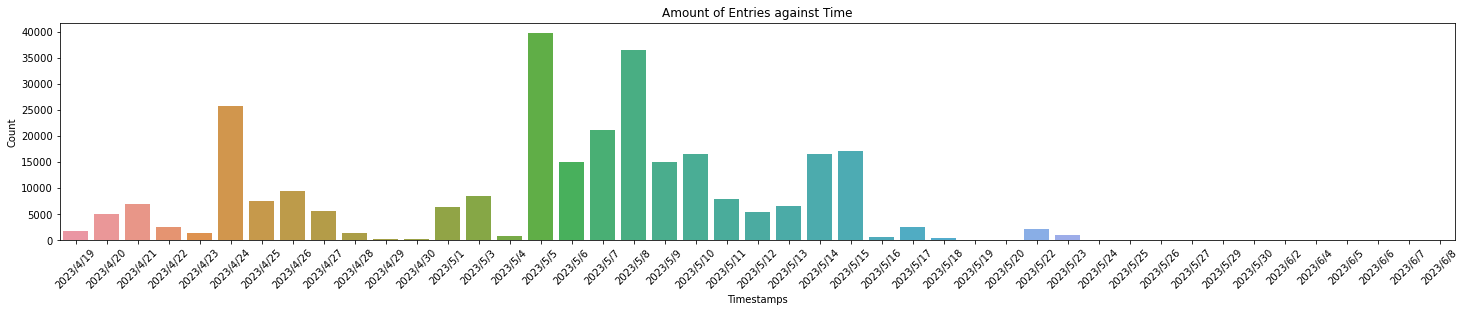

In [206]:
plt.figure().set_figwidth(25)
barplot_time = sns.barplot(data = df_timestamps, x = 'Timestamps',y = 'Count').set(title = "Amount of Entries against Time")
plt.xticks(rotation= 45)
plt.show()

## Now, lets connect everything with user
**Question** --> would it be more useful to use filtered_data or filtered_data1. Where the first removes reports with "none" as a user_id, or the second where it only removes entries that do not record an origin website. As this is a more user centric approach, would moving back to fitlered_data be more appropriate? Or does this hinder our exploration by sort of confusing what we are seeing

In [34]:
list_user = []
for i in filtered_data1: 
    a = i.get('report')['user_id']
    list_user.append(a)
print(f'There are in total {len(list_user)} entries of multiple users, and {len(set(list_user))} unique users')

There are in total 354159 entries of multiple users, and 19 unique users


In [35]:
dict_user = simple_produce_count(list_user)
df_users = pd.DataFrame.from_dict({"Users": list(dict_user.keys()),"Appearances": list(dict_user.values())})
df_users

,Users,Appearances
0,dknglbh1h3,146866
1,zu7pjmkeoi,99105
2,None,98047
3,s4ni7dbb7y,8642
4,699mztw4z75,476
5,4485kqex0zs,285
6,grr97iqp57r,190
7,jktgjnvw8r,169
8,l9duvpdz9m8,119
9,4q68v2cg2pl,76


### Let's add the leak-type per user

In [36]:
#connecting user_id, and what types of fields are leaked and how many times they are found
dict_user_leak = {}

for i in filtered_data1: 
    report = i['report']
    #getting user (which will be the keys)
    if report.get('user_id') != None:     
        user = report["user_id"]
    else: 
        user = "None"
        
    #getting leak types (which will be the keys for the nested dict for each url)
    if report['url_leak_type'] == None: 
        leak_type = "None"
    else: 
        leak_type = report['url_leak_type']
        leak_type = (sorted(leak_type)) #ADDING THE SORTED REMOVES FIELD DUPLICATES

    if user in dict_user_leak: 
        #dic.get('b') == None: <-- another way to find 
        if leak_type in dict_user_leak[user]: 
            dict_user_leak[user][leak_type] += 1
        else: 
            dict_user_leak[user][leak_type] = 1
    else: 
        dict_user_leak[user] = {} #results in empty field dicts for some urls

TypeError: unhashable type: 'list'